In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [3]:
#sample_sub=pd.read_csv('sample_submission.csv')
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [5]:
pd.Series(list(set(train['Product_ID']).intersection(set(test['Product_ID']))))

0       P00010342
1       P00310942
2       P00051242
3       P00199642
4       P00316042
5       P00354242
6       P00033842
7       P00013642
8       P00266642
9       P00265742
10      P00157442
11      P00261442
12      P00255742
13      P00299842
14      P00057642
15      P00321542
16      P00226342
17      P00182842
18      P00008542
19      P00291342
20      P00066442
21      P00119542
22      P00270442
23      P00353442
24      P00085742
25      P00330042
26      P00139042
27      P00154542
28      P00056242
29      P00213542
          ...    
3415    P00032242
3416    P00233542
3417    P00117142
3418    P00078742
3419    P00202342
3420    P00220342
3421    P00115142
3422    P00291942
3423    P00170042
3424    P00223542
3425    P00217842
3426    P00043142
3427    P00189342
3428    P00116842
3429    P00032642
3430    P00289942
3431    P00249642
3432    P00309442
3433    P00158842
3434    P00029442
3435    P00118542
3436    P00076142
3437    P00072442
3438    P00011342
3439    P0

In [6]:
from sklearn.preprocessing import LabelEncoder
l_col=['City_Category','Stay_In_Current_City_Years','Gender']
for df in test,train:
    for col in l_col:
        l=LabelEncoder()
        train[col]=l.fit_transform(train[col])
        test[col]=l.fit_transform(test[col])
        
#l.classes_

In [7]:
age=("0-17","18-25","26-35","36-45","46-50","51-55","55+")
for df in train,test:
    for key,value in zip(age,(15,21,30,40,48,53,60)):
             df.loc[df['Age']==key,'Age']=int(value)
    
    df['Age']=df.Age.astype(int)

 

In [10]:
intersection=pd.Series(list(set(train['Product_ID']).intersection(set(test['Product_ID']))))
intersection=np.array(intersection)
intersection

array(['P00010342', 'P00310942', 'P00051242', ..., 'P00000242',
       'P00014342', 'P0095342'], dtype=object)

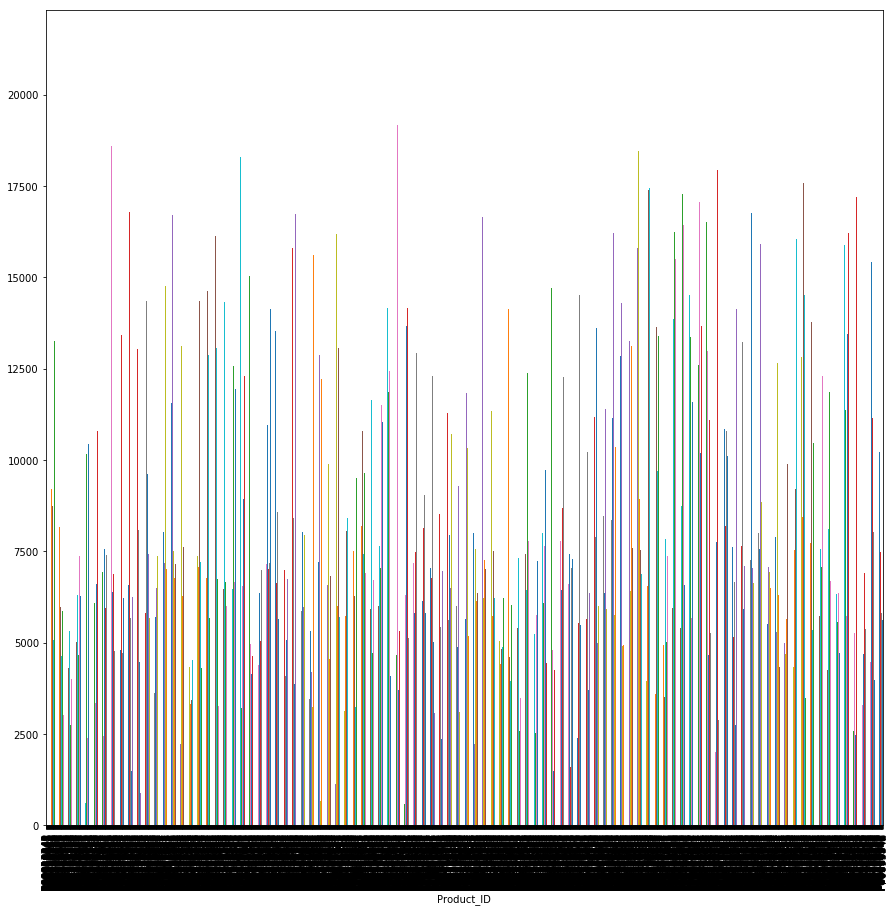

In [11]:
cd=train.groupby(['Product_ID'])['Purchase'].sum()
cd=pd.DataFrame(cd,columns=['Purchase'])
cd['count']=train.groupby(['Product_ID'])['Purchase'].count()
cd['per_user']=cd['Purchase']/cd['count']
cd=cd.loc[intersection]
plt.figure(figsize=(15,15))
cd['per_user'].plot(kind='bar')
plt.show()

In [12]:
cd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3445 entries, P00010342 to P0095342
Data columns (total 3 columns):
Purchase    3445 non-null int64
count       3445 non-null int64
per_user    3445 non-null float64
dtypes: float64(1), int64(2)
memory usage: 107.7+ KB


In [13]:
train['Product_ID'][~train['Product_ID'].isin(test['Product_ID'])]


261       P00305542
7251      P00340242
7814      P00340242
10906     P00340242
11513     P00020742
12816     P00248242
13059     P00356142
13576     P00301042
13865     P00182942
16197     P00340242
16799     P00162542
16951     P00308942
20272     P00182942
22076     P00363042
22970     P00071342
22971     P00055942
23863     P00203942
27252     P00103542
30146     P00080942
31169     P00157242
31643     P00069942
31807     P00318042
32246     P00308942
39636     P00077542
42941     P00266342
44633     P00283442
45018     P00283442
45397     P00013242
45795     P00072142
45809     P00065842
            ...    
550038    P00375436
550039    P00371644
550040    P00370853
550041    P00371644
550042    P00371644
550043    P00370293
550044    P00370853
550045    P00371644
550046    P00375436
550047    P00372445
550048    P00371644
550049    P00375436
550050    P00371644
550051    P00375436
550052    P00375436
550053    P00371644
550054    P00370293
550055    P00372445
550056    P00375436


In [14]:
def getCountVar(compute_df, count_df, var_name):
        grouped_df = count_df.groupby(var_name)
        count_dict = {}
        for name, group in grouped_df:
                count_dict[name] = group.shape[0]

        count_list = []
        for index, row in compute_df.iterrows():
                name = row[var_name]
                count_list.append(count_dict.get(name, 0))
        return count_list

def getPurchaseVar(compute_df, purchase_df, var_name):
        grouped_df = purchase_df.groupby(var_name)
        min_dict = {}
        max_dict = {}
        mean_dict = {}
        twentyfive_dict = {}
        seventyfive_dict = {}
        for name, group in grouped_df:
                min_dict[name] = min(np.array(group["Purchase"]))
                max_dict[name] = max(np.array(group["Purchase"]))
                mean_dict[name] = np.mean(np.array(group["Purchase"]))
                twentyfive_dict[name] = np.percentile(np.array(group["Purchase"]),25)
                seventyfive_dict[name] = np.percentile(np.array(group["Purchase"]),75)

        min_list = []
        max_list = []
        mean_list = []
        twentyfive_list = []
        seventyfive_list = []
        for index, row in compute_df.iterrows():
                name = row[var_name]
                min_list.append(min_dict.get(name,0))
                max_list.append(max_dict.get(name,0))
                mean_list.append(mean_dict.get(name,0))
                twentyfive_list.append( twentyfive_dict.get(name,0))
                seventyfive_list.append( seventyfive_dict.get(name,0))

        return min_list, max_list, mean_list, twentyfive_list, seventyfive_list



In [15]:
train['Product_int']=train['Product_ID'].apply(lambda x: int(x[1:]))
test['Product_int']=test['Product_ID'].apply(lambda x: int(x[1:]))


In [16]:
train["Occupation_Count"] = getCountVar(train, train, "Occupation")
test["Occupation_Count"] = getCountVar(test, train, "Occupation")
train["Product_Category_1_Count"] = getCountVar(train, train, "Product_Category_1")
test["Product_Category_1_Count"] = getCountVar(test, train, "Product_Category_1")
train["Product_Category_2_Count"] = getCountVar(train, train, "Product_Category_2")
test["Product_Category_2_Count"] = getCountVar(test, train, "Product_Category_2")
train["Product_Category_3_Count"] = getCountVar(train, train, "Product_Category_3")
test["Product_Category_3_Count"] = getCountVar(test, train, "Product_Category_3")
train["User_ID_Count"] = getCountVar(train, train, "User_ID")
test["User_ID_Count"] = getCountVar(test, train, "User_ID")
train["Product_ID_Count"] = getCountVar(train, train, "Product_ID")
test["Product_ID_Count"] = getCountVar(test, train, "Product_ID")


test["Age_Count"] = getCountVar(test, train, "Age")
train["Age_Count"] = getCountVar(train, train, "Age")

test["occupation_Count"] = getCountVar(test, train, "Occupation")
train["occupation_Count"] = getCountVar(train, train, "Occupation")


In [17]:
#train.fillna(-999, inplace=True)
#test.fillna(-999, inplace=True)


In [19]:
'''
def getProductVar(purchase_df,category, var_name):
        grouped_df = purchase_df.groupby(var_name)
        min_dict = {}
        max_dict = {}
        mean_dict = {}
        twentyfive_dict = {}
        seventyfive_dict = {}
        for name, group in grouped_df:
                min_dict[name] = min(np.array(group[category]))
                max_dict[name] = max(np.array(group[category]))
                mean_dict[name] = np.mean(np.array(group[category]))
                twentyfive_dict[name] = np.percentile(np.array(group[category]),25)
                seventyfive_dict[name] = np.percentile(np.array(group[category]),75)

        min_list = []
        max_list = []
        mean_list = []
        twentyfive_list = []
        seventyfive_list = []
        for index, row in purchase_df.iterrows():
                name = row[var_name]
                min_list.append(min_dict.get(name,0))
                max_list.append(max_dict.get(name,0))
                mean_list.append(mean_dict.get(name,0))
                twentyfive_list.append( twentyfive_dict.get(name,0))
                seventyfive_list.append( seventyfive_dict.get(name,0))

        return min_list, max_list, mean_list, twentyfive_list, seventyfive_list
    
    
    

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getProductVar(train,'Product_Category_1', "User_ID")

train["User_ID_MinCat1"] = min_price_list
train["User_ID_MaxCat1"] = max_price_list
train["User_ID_MeanCat1"] = mean_price_list
train["User_ID_25PercCat1"] = twentyfive_price_list
train["User_ID_75PercCat1"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getProductVar(test,'Product_Category_1', "User_ID")

test["User_ID_MinCat1"] = min_price_list
test["User_ID_MaxCat1"] = max_price_list
test["User_ID_MeanCat1"] = mean_price_list
test["User_ID_25PercCat1"] = twentyfive_price_list
test["User_ID_75PercCat1"] = seventyfive_price_list
'''


'\ndef getProductVar(purchase_df,category, var_name):\n        grouped_df = purchase_df.groupby(var_name)\n        min_dict = {}\n        max_dict = {}\n        mean_dict = {}\n        twentyfive_dict = {}\n        seventyfive_dict = {}\n        for name, group in grouped_df:\n                min_dict[name] = min(np.array(group[category]))\n                max_dict[name] = max(np.array(group[category]))\n                mean_dict[name] = np.mean(np.array(group[category]))\n                twentyfive_dict[name] = np.percentile(np.array(group[category]),25)\n                seventyfive_dict[name] = np.percentile(np.array(group[category]),75)\n\n        min_list = []\n        max_list = []\n        mean_list = []\n        twentyfive_list = []\n        seventyfive_list = []\n        for index, row in purchase_df.iterrows():\n                name = row[var_name]\n                min_list.append(min_dict.get(name,0))\n                max_list.append(max_dict.get(name,0))\n                mea

In [20]:

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "User_ID")

train["User_ID_MinPrice"] = min_price_list
train["User_ID_MaxPrice"] = max_price_list
train["User_ID_MeanPrice"] = mean_price_list
train["User_ID_25PercPrice"] = twentyfive_price_list
train["User_ID_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "User_ID")

test["User_ID_MinPrice"] = min_price_list
test["User_ID_MaxPrice"] = max_price_list
test["User_ID_MeanPrice"] = mean_price_list
test["User_ID_25PercPrice"] = twentyfive_price_list
test["User_ID_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Product_ID")

train["Product_ID_MinPrice"] = min_price_list
train["Product_ID_MaxPrice"] = max_price_list
train["Product_ID_MeanPrice"] = mean_price_list
train["Product_ID_25PercPrice"] = twentyfive_price_list
train["Product_ID_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Product_ID")

test["Product_ID_MinPrice"] = min_price_list
test["Product_ID_MaxPrice"] = max_price_list
test["Product_ID_MeanPrice"] = mean_price_list
test["Product_ID_25PercPrice"] = twentyfive_price_list
test["Product_ID_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Product_Category_1")

train["Product_Cat1_MinPrice"] = min_price_list
train["Product_Cat1_MaxPrice"] = max_price_list
train["Product_Cat1_MeanPrice"] = mean_price_list
train["Product_Cat1_25PercPrice"] = twentyfive_price_list
train["Product_Cat1_75PercPrice"]    = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Product_Category_1")
test["Product_Cat1_MinPrice"] = min_price_list
test["Product_Cat1_MaxPrice"] = max_price_list
test["Product_Cat1_MeanPrice"] = mean_price_list
test["Product_Cat1_25PercPrice"] = twentyfive_price_list
test["Product_Cat1_75PercPrice"] = seventyfive_price_list


min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Product_Category_2")

train["Product_Cat2_MinPrice"] = min_price_list
train["Product_Cat2_MaxPrice"] = max_price_list
train["Product_Cat2_MeanPrice"] = mean_price_list
train["Product_Cat2_25PercPrice"] = twentyfive_price_list
train["Product_Cat2_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Product_Category_2")
test["Product_Cat2_MinPrice"] = min_price_list
test["Product_Cat2_MaxPrice"] = max_price_list
test["Product_Cat2_MeanPrice"] = mean_price_list
test["Product_Cat2_25PercPrice"] = twentyfive_price_list
test["Product_Cat2_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Product_Category_3")

train["Product_Cat3_MinPrice"] = min_price_list
train["Product_Cat3_MaxPrice"] = max_price_list
train["Product_Cat3_MeanPrice"] = mean_price_list
train["Product_Cat3_25PercPrice"] = twentyfive_price_list
train["Product_Cat3_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Product_Category_3")
test["Product_Cat3_MinPrice"] = min_price_list
test["Product_Cat3_MaxPrice"] = max_price_list
test["Product_Cat3_MeanPrice"] = mean_price_list
test["Product_Cat3_25PercPrice"] = twentyfive_price_list
test["Product_Cat3_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Occupation")

train["Occupation_MinPrice"] = min_price_list
train["Occupation_MaxPrice"] = max_price_list
train["Occupation_MeanPrice"] = mean_price_list
train["Occupation_25PercPrice"] = twentyfive_price_list
train["Occupation_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Occupation")
test["Occupation_MinPrice"] = min_price_list
test["Occupation_MaxPrice"] = max_price_list
test["Occupation_MeanPrice"] = mean_price_list
test["Occupation_25PercPrice"] = twentyfive_price_list
test["Occupation_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Age")

train["Age_MinPrice"] = min_price_list
train["Age_MaxPrice"] = max_price_list
train["Age_MeanPrice"] = mean_price_list
train["Age_25PercPrice"] = twentyfive_price_list
train["Age_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Age")
test["Age_MinPrice"] = min_price_list
test["Age_MaxPrice"] = max_price_list
test["Age_MeanPrice"] = mean_price_list
test["Age_25PercPrice"] = twentyfive_price_list
test["Age_75PercPrice"] = seventyfive_price_list




In [21]:
'''
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Stay_In_Current_City_Years")

train["stay_MinPrice"] = min_price_list
train["stay_MaxPrice"] = max_price_list
train["stay_MeanPrice"] = mean_price_list
train["stay_25PercPrice"] = twentyfive_price_list
train["stay_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Stay_In_Current_City_Years")
test["stay_MinPrice"] = min_price_list
test["stay_MaxPrice"] = max_price_list
test["stay_MeanPrice"] = mean_price_list
test["stay_25PercPrice"] = twentyfive_price_list
test["stay_75PercPrice"] = seventyfive_price_list


min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Gender")

train["gender_MinPrice"] = min_price_list
train["gender_MaxPrice"] = max_price_list
train["gender_MeanPrice"] = mean_price_list
train["gender_25PercPrice"] = twentyfive_price_list
train["gender_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Gender")
test["gender_MinPrice"] = min_price_list
test["gender_MaxPrice"] = max_price_list
test["gender_MeanPrice"] = mean_price_list
test["gender_25PercPrice"] = twentyfive_price_list
test["gender_75PercPrice"] = seventyfive_price_list

min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "City_Category")

train["city_MinPrice"] = min_price_list
train["city_MaxPrice"] = max_price_list
train["city_MeanPrice"] = mean_price_list
train["city_25PercPrice"] = twentyfive_price_list
train["city_75PercPrice"] = seventyfive_price_list
min_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "City_Category")
test["city_MinPrice"] = min_price_list
test["city_MaxPrice"] = max_price_list
test["city_MeanPrice"] = mean_price_list
test["city_25PercPrice"] = twentyfive_price_list
test["city_75PercPrice"] = seventyfive_price_list
'''

'\nmin_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Stay_In_Current_City_Years")\n\ntrain["stay_MinPrice"] = min_price_list\ntrain["stay_MaxPrice"] = max_price_list\ntrain["stay_MeanPrice"] = mean_price_list\ntrain["stay_25PercPrice"] = twentyfive_price_list\ntrain["stay_75PercPrice"] = seventyfive_price_list\nmin_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(test, train, "Stay_In_Current_City_Years")\ntest["stay_MinPrice"] = min_price_list\ntest["stay_MaxPrice"] = max_price_list\ntest["stay_MeanPrice"] = mean_price_list\ntest["stay_25PercPrice"] = twentyfive_price_list\ntest["stay_75PercPrice"] = seventyfive_price_list\n\n\nmin_price_list, max_price_list, mean_price_list, twentyfive_price_list, seventyfive_price_list = getPurchaseVar(train, train, "Gender")\n\ntrain["gender_MinPrice"] = min_price_list\ntrain["gender_MaxPrice"] = max_price_list\ntr

In [22]:
#train.to_csv('new_train.csv',index=False)
#test.to_csv('new_test.csv',index=False)

In [23]:
#train=pd.read_csv('new_train.csv')
#test=pd.read_csv('new_test.csv')

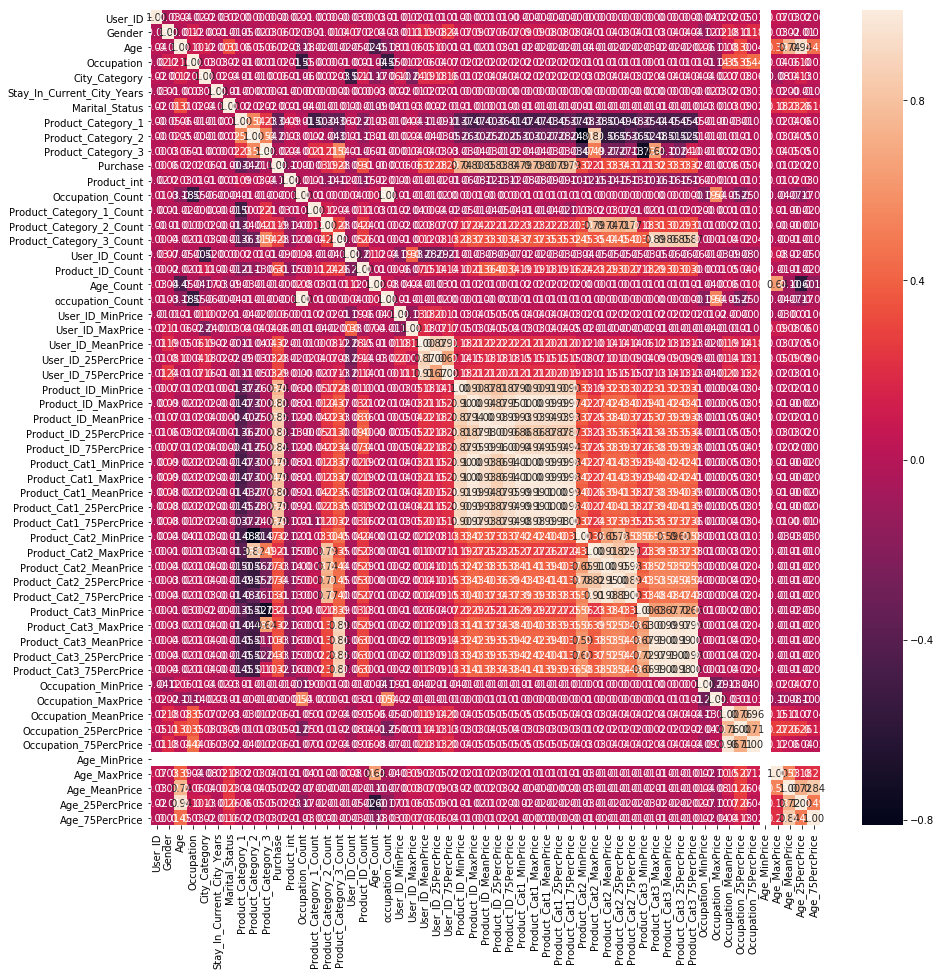

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), annot=True, fmt=".2f")
plt.show()

In [25]:
'''
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
k_range = list(range(1, 31))
k_range2=list(range(-10,20))
k3_range=list(np.linspace(0.1,1,50))
#alpha=list([1e-5, 1e-2, 0.1, 1, 100])
k4_range=list(np.linspace(0,0.1,50))

print(k_range)
param_grid = dict(max_depth=k_range,
                  max_delta_step=k_range,
                  nthread=k_range2,
                  min_child_weight=k_range,
                  scale_pos_weight=k_range,
                  subsample=k3_range,
                  gamma=k3_range,
                  reg_alpha=k3_range,
                  learning_rate =k4_range,
                  colsample_bytree=k3_range,
                 seed=k_range)
print(param_grid)
knn=xgb.XGBRegressor(n_estimators=200)
grid =GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error')

grid.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
grid.grid_scores_
'''

"\nfrom sklearn.grid_search import GridSearchCV\nfrom sklearn.grid_search import RandomizedSearchCV\nk_range = list(range(1, 31))\nk_range2=list(range(-10,20))\nk3_range=list(np.linspace(0.1,1,50))\n#alpha=list([1e-5, 1e-2, 0.1, 1, 100])\nk4_range=list(np.linspace(0,0.1,50))\n\nprint(k_range)\nparam_grid = dict(max_depth=k_range,\n                  max_delta_step=k_range,\n                  nthread=k_range2,\n                  min_child_weight=k_range,\n                  scale_pos_weight=k_range,\n                  subsample=k3_range,\n                  gamma=k3_range,\n                  reg_alpha=k3_range,\n                  learning_rate =k4_range,\n                  colsample_bytree=k3_range,\n                 seed=k_range)\nprint(param_grid)\nknn=xgb.XGBRegressor(n_estimators=200)\ngrid =GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error')\n\ngrid.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])\ngrid.grid_scores_\n"

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test=train_test_split(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
k_range = list(range(1, 31))
k_range2=list(range(-10,20))
k3_range=list(np.linspace(0,1,50))

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.03
params["gamma"] = 0.2
params["reg_alpha"] = 0.64
params["min_child_weight"] = 22
params["subsample"] = 0.85
params["colsample_bytree"] = 0.55
params["colsample_bylevel"] = 0.64
params["silent"] = 1
params["max_depth"] = 12
#params["max_delta_step"]=2
params["seed"] = 0
#params['eval_metric'] = "auc"
plst = list(params.items())

num_boost_round=1000
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(plst, dtrain, num_boost_round, evals=watchlist,
                early_stopping_rounds=500, verbose_eval=True)


[0]	train-rmse:10247.7	eval-rmse:10234
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 500 rounds.
[1]	train-rmse:9959.32	eval-rmse:9946.02
[2]	train-rmse:9680.53	eval-rmse:9667.57
[3]	train-rmse:9409.78	eval-rmse:9397.23
[4]	train-rmse:9148.11	eval-rmse:9135.95
[5]	train-rmse:8895	eval-rmse:8883.23
[6]	train-rmse:8649.51	eval-rmse:8638.25
[7]	train-rmse:8411.72	eval-rmse:8401.01
[8]	train-rmse:8181.87	eval-rmse:8171.74
[9]	train-rmse:7959.3	eval-rmse:7949.68
[10]	train-rmse:7744.21	eval-rmse:7735.18
[11]	train-rmse:7537	eval-rmse:7528.65
[12]	train-rmse:7335.57	eval-rmse:7328.03
[13]	train-rmse:7140.54	eval-rmse:7133.76
[14]	train-rmse:6952.26	eval-rmse:6946.29
[15]	train-rmse:6770.15	eval-rmse:6764.94
[16]	train-rmse:6594	eval-rmse:6589.67
[17]	train-rmse:6423.86	eval-rmse:6420.43
[18]	train-rmse:6259.59	eval-rmse:6257.13
[19]	train-rmse:6100.86	eval-rmse:6099.4
[20]	train-rmse:5947.72	eval-rmse:5947.

[192]	train-rmse:2169.23	eval-rmse:2399.29
[193]	train-rmse:2168.06	eval-rmse:2399.05
[194]	train-rmse:2166.91	eval-rmse:2398.92
[195]	train-rmse:2165.71	eval-rmse:2398.54
[196]	train-rmse:2164.63	eval-rmse:2398.43
[197]	train-rmse:2163.6	eval-rmse:2398.19
[198]	train-rmse:2163.15	eval-rmse:2398.08
[199]	train-rmse:2162.11	eval-rmse:2397.99
[200]	train-rmse:2161.54	eval-rmse:2397.87
[201]	train-rmse:2160.66	eval-rmse:2397.71
[202]	train-rmse:2160.06	eval-rmse:2397.54
[203]	train-rmse:2159.43	eval-rmse:2397.51
[204]	train-rmse:2159.14	eval-rmse:2397.42
[205]	train-rmse:2158.12	eval-rmse:2397.31
[206]	train-rmse:2157.4	eval-rmse:2397.2
[207]	train-rmse:2156.72	eval-rmse:2397.13
[208]	train-rmse:2155.64	eval-rmse:2396.88
[209]	train-rmse:2154.93	eval-rmse:2396.8
[210]	train-rmse:2153.48	eval-rmse:2396.4
[211]	train-rmse:2152.18	eval-rmse:2396.26
[212]	train-rmse:2151.49	eval-rmse:2396.15
[213]	train-rmse:2150.53	eval-rmse:2395.97
[214]	train-rmse:2149.65	eval-rmse:2395.82
[215]	train-rmse

[384]	train-rmse:2044.94	eval-rmse:2384.42
[385]	train-rmse:2044.23	eval-rmse:2384.39
[386]	train-rmse:2043.43	eval-rmse:2384.34
[387]	train-rmse:2042.97	eval-rmse:2384.31
[388]	train-rmse:2042.51	eval-rmse:2384.26
[389]	train-rmse:2042.17	eval-rmse:2384.26
[390]	train-rmse:2041.78	eval-rmse:2384.22
[391]	train-rmse:2041.56	eval-rmse:2384.23
[392]	train-rmse:2040.62	eval-rmse:2384.19
[393]	train-rmse:2040.06	eval-rmse:2384.18
[394]	train-rmse:2039.86	eval-rmse:2384.2
[395]	train-rmse:2039.23	eval-rmse:2384.21
[396]	train-rmse:2038.47	eval-rmse:2384.09
[397]	train-rmse:2038.1	eval-rmse:2384.06
[398]	train-rmse:2037.92	eval-rmse:2384.08
[399]	train-rmse:2037.63	eval-rmse:2384.04
[400]	train-rmse:2037.39	eval-rmse:2384.04
[401]	train-rmse:2036.93	eval-rmse:2384.03
[402]	train-rmse:2036.46	eval-rmse:2384.01
[403]	train-rmse:2035.65	eval-rmse:2383.95
[404]	train-rmse:2035.21	eval-rmse:2383.92
[405]	train-rmse:2034.76	eval-rmse:2383.86
[406]	train-rmse:2034.47	eval-rmse:2383.83
[407]	train-r

[576]	train-rmse:1949.8	eval-rmse:2381.8
[577]	train-rmse:1949.31	eval-rmse:2381.79
[578]	train-rmse:1949.19	eval-rmse:2381.79
[579]	train-rmse:1948.82	eval-rmse:2381.76
[580]	train-rmse:1948.22	eval-rmse:2381.73
[581]	train-rmse:1948.02	eval-rmse:2381.73
[582]	train-rmse:1947.46	eval-rmse:2381.71
[583]	train-rmse:1946.73	eval-rmse:2381.67
[584]	train-rmse:1946.18	eval-rmse:2381.67
[585]	train-rmse:1945.88	eval-rmse:2381.68
[586]	train-rmse:1945.39	eval-rmse:2381.72
[587]	train-rmse:1944.83	eval-rmse:2381.68
[588]	train-rmse:1944.64	eval-rmse:2381.68
[589]	train-rmse:1944.19	eval-rmse:2381.68
[590]	train-rmse:1943.72	eval-rmse:2381.65
[591]	train-rmse:1943.41	eval-rmse:2381.66
[592]	train-rmse:1942.92	eval-rmse:2381.64
[593]	train-rmse:1942.52	eval-rmse:2381.61
[594]	train-rmse:1942.06	eval-rmse:2381.6
[595]	train-rmse:1941.9	eval-rmse:2381.61
[596]	train-rmse:1941.58	eval-rmse:2381.63
[597]	train-rmse:1941.09	eval-rmse:2381.66
[598]	train-rmse:1940.81	eval-rmse:2381.66
[599]	train-rms

[768]	train-rmse:1864.2	eval-rmse:2382.07
[769]	train-rmse:1863.94	eval-rmse:2382.1
[770]	train-rmse:1863.73	eval-rmse:2382.12
[771]	train-rmse:1863.5	eval-rmse:2382.12
[772]	train-rmse:1862.92	eval-rmse:2382.13
[773]	train-rmse:1862.47	eval-rmse:2382.18
[774]	train-rmse:1861.71	eval-rmse:2382.2
[775]	train-rmse:1861.4	eval-rmse:2382.19
[776]	train-rmse:1861.1	eval-rmse:2382.16
[777]	train-rmse:1860.8	eval-rmse:2382.15
[778]	train-rmse:1860.63	eval-rmse:2382.14
[779]	train-rmse:1860.29	eval-rmse:2382.14
[780]	train-rmse:1859.48	eval-rmse:2382.11
[781]	train-rmse:1859.02	eval-rmse:2382.15
[782]	train-rmse:1858.62	eval-rmse:2382.14
[783]	train-rmse:1858.22	eval-rmse:2382.16
[784]	train-rmse:1857.8	eval-rmse:2382.15
[785]	train-rmse:1857.27	eval-rmse:2382.15
[786]	train-rmse:1856.53	eval-rmse:2382.11
[787]	train-rmse:1856.13	eval-rmse:2382.12
[788]	train-rmse:1855.97	eval-rmse:2382.12
[789]	train-rmse:1855.6	eval-rmse:2382.14
[790]	train-rmse:1855.08	eval-rmse:2382.18
[791]	train-rmse:185

[960]	train-rmse:1787.4	eval-rmse:2383.61
[961]	train-rmse:1786.79	eval-rmse:2383.63
[962]	train-rmse:1786.6	eval-rmse:2383.64
[963]	train-rmse:1786.29	eval-rmse:2383.67
[964]	train-rmse:1785.74	eval-rmse:2383.7
[965]	train-rmse:1785.37	eval-rmse:2383.7
[966]	train-rmse:1784.85	eval-rmse:2383.71
[967]	train-rmse:1784.3	eval-rmse:2383.72
[968]	train-rmse:1784.11	eval-rmse:2383.74
[969]	train-rmse:1783.79	eval-rmse:2383.75
[970]	train-rmse:1783.22	eval-rmse:2383.79
[971]	train-rmse:1782.95	eval-rmse:2383.82
[972]	train-rmse:1782.37	eval-rmse:2383.84
[973]	train-rmse:1781.84	eval-rmse:2383.84
[974]	train-rmse:1781.34	eval-rmse:2383.84
[975]	train-rmse:1780.8	eval-rmse:2383.87
[976]	train-rmse:1780.57	eval-rmse:2383.86
[977]	train-rmse:1780.06	eval-rmse:2383.83
[978]	train-rmse:1779.61	eval-rmse:2383.83
[979]	train-rmse:1778.9	eval-rmse:2383.8
[980]	train-rmse:1778.63	eval-rmse:2383.79
[981]	train-rmse:1778.16	eval-rmse:2383.78
[982]	train-rmse:1777.95	eval-rmse:2383.81
[983]	train-rmse:17

In [ ]:
from sklearn.metrics import mean_squared_error
#k_range=list(range(1,100,10))
k_range=list(np.linspace(0.01,0.2,21))

for k in k_range:
    par=xgb.XGBRegressor(n_estimators=50,max_depth=12,min_child_weight=22,
                         gamma=0.2,subsample=0.85, colsample_bylevel=0.64,colsample_bytree=0.55
                         ,reg_alpha=0.64,learning_rate=0.164)
    par.fit(X_train,y_train)
    pred=par.predict(X_test)
    print(k,mean_squared_error(pred,y_test))

0.01 5828346.04854
0.0195 5828346.04854
0.029 5828346.04854
0.0385 5828346.04854


In [ ]:
'''

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(10,15)
    for min_child_weight in range(0,15)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = 5
    params['min_child_weight'] = 5

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))
'''

'\n\ngridsearch_params = [\n    (max_depth, min_child_weight)\n    for max_depth in range(10,15)\n    for min_child_weight in range(0,15)\n]\n\nmin_mae = float("Inf")\nbest_params = None\nfor max_depth, min_child_weight in gridsearch_params:\n    print("CV with max_depth={}, min_child_weight={}".format(\n                             max_depth,\n                             min_child_weight))\n\n    # Update our parameters\n    params[\'max_depth\'] = 5\n    params[\'min_child_weight\'] = 5\n\n    # Run CV\n    cv_results = xgb.cv(\n        params,\n        dtrain,\n        num_boost_round=num_boost_round,\n        metrics={\'mae\'},\n        early_stopping_rounds=10\n    )\n\n    # Update best MAE\n    mean_mae = cv_results[\'test-mae-mean\'].min()\n    boost_rounds = cv_results[\'test-mae-mean\'].argmin()\n    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))\n    if mean_mae < min_mae:\n        min_mae = mean_mae\n        best_params = (max_depth,min_child_weight)\n\npri

In [ ]:


reg=xgb.XGBRegressor(n_estimators=50,
                     max_depth=12,
                     min_child_weight=22,
                     gamma=0.2,
                     subsample=0.85,
                     colsample_bylevel=0.64,
                     colsample_bytree=0.55
                     ,reg_alpha=0.64)
reg.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
pred=reg.predict(test.drop(['Product_ID'],axis=1))
pred

In [ ]:
pred.std()

In [ ]:
params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.03
params["gamma"] = 0.2
params["reg_alpha"] = 0.64
params["min_child_weight"] = 22
params["subsample"] = 0.85
params["colsample_bytree"] = 0.55
params["colsample_bylevel"] = 0.64
params["silent"] = 1
params["max_depth"] = 12
#params["max_delta_step"]=2
params["seed"] = 0
#params['eval_metric'] = "auc"
plst = list(params.items())

num_rounds = 1100
xgtrain = xgb.DMatrix(train.drop(['Purchase','Product_ID'],axis=1),train['Purchase'])
xgtest = xgb.DMatrix(test.drop(['Product_ID'],axis=1))
model = xgb.train(plst, xgtrain, num_rounds)
pred_test_y = model.predict(xgtest)
pred_train_y = model.predict(xgtrain)
pred_test_y


In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg_rf=RandomForestRegressor(n_estimators=200)
reg_rf.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
pred_rf=reg_rf.predict(test.drop(['Product_ID'],axis=1))
pred_rf

In [ ]:
from sklearn import linear_model
reg_linear=linear_model.LinearRegression()
reg_linear.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
pred_linear=reg_linear.predict(test.drop(['Product_ID'],axis=1))
pred_linear

In [ ]:
from sklearn.ensemble import BaggingRegressor
reg_ad=BaggingRegressor(n_estimators=50)
reg_ad.fit(train.drop(['Product_ID','Purchase'],axis=1),train['Purchase'])
pred_ad=reg_ad.predict(test.drop(['Product_ID'],axis=1))
pred_ad


In [ ]:
pred_ad.std()

In [ ]:
from sklearn.metrics import mean_squared_error
x=mean_squared_error(pred_ad,pred_new)
np.sqrt(x)

In [ ]:
pred_new=(0.15*pred+0.85*pred_test_y)*1.4-0.4*pred_ad

In [ ]:
xgb.plot_importance(model)
plt.show()

In [ ]:
sub

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(pred_ad,'.')
#plt.show()

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(pred_new,'.')
#plt.show()

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(pred_rf,'.')
#plt.show()

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(pred,'.')
#plt.show()

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(pred_test_y,'.')
#plt.show()

In [ ]:
#plt.figure(figsize=(15,15))
#plt.plot(train['Purchase'],'.')
#plt.show()

In [ ]:
'''
new=[]
for x in pred_new:
    if(x>22000 and x<25000):
        y=23000     
        x=x-(x-y)*0.5
    if(x>18500 and x<22000):
        y=20000
        x=x-(x-y)*0.5
    if(x>14000 and x<18500):
        y=17000     
        x=x-(x-y)*0.5
    if(x>11500 and x<14000):
        y=12500     
        x=x-(x-y)*0.5
    if(x>10500 and x<11500):
        y=11000     
        x=x-(x-y)*0.5
    if(x>9000 and x<10000):
        y=9500     
        x=x-(x-y)*0.5
    if(x>7500 and x<9000):
        y=8000     
        x=x-(x-y)*0.5
    if(x>5500 and x<6500):
        y=6000     
        x=x-(x-y)*0.5
    if(x>2500 and x<5500):
        y=4000     
        x=x-(x-y)*0.5
    if(x>1500 and x<3000):
        y=2000     
        x=x-(x-y)*0.5
            
    new.append(x)  
new=np.array(new)    
plt.figure(figsize=(15,15))
plt.plot(new,'.')
plt.show()    
'''

In [ ]:
sub=pd.DataFrame()
sub[['User_ID','Product_ID']]=test[['User_ID','Product_ID']]
sub['Purchase']=pred_new
sub.to_csv('first_sub.csv',index=False)

# Introducing Ensembling of Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVC


In [ ]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }


In [ ]:
y_train = train['Purchase'].ravel()
train = train.drop(['Purchase'], axis=1)
x_train = train.drop("Product_ID",axis=1).values # Creates an array of the train data
x_test = test.drop("Product_ID",axis=1).values # Creats an array of the test data


In [ ]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.feature_importances_)


In [ ]:
from sklearn.cross_validation import KFold;


ntrain = train.shape[0]
ntest = test.shape[0]
NFOLDS = 5 # set folds for out-of-fold prediction
SEED = 0
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)



In [ ]:
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [ ]:
clf_rf=rf.fit(x_train,y_train)
clf_et=et.fit(x_train,y_train)
clf_ada=ada.fit(x_train,y_train)
clf_gb=gb.fit(x_train,y_train)

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)


In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

